In [59]:
import cv2
import os
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

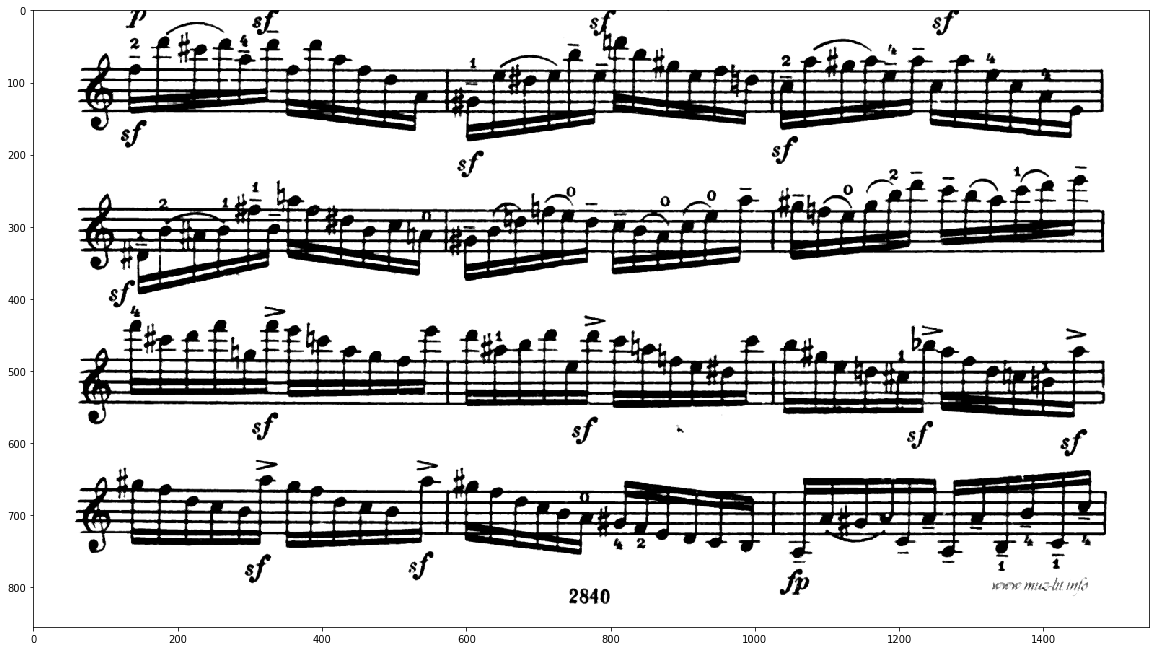

In [487]:
# Reading the file
note_path = 'note2.png'
note = cv2.imread(note_path)
note = cv2.cvtColor(note, cv2.COLOR_BGR2GRAY)
note = cv2.medianBlur(note, 3)

# Let's just work with the bottom half first
note = note[note.shape[0] // 2 + 200:, :]

# Let's see what we have now, visualization is very important
plt.figure(figsize=(20, 12))
plt.imshow(note, 'gray')

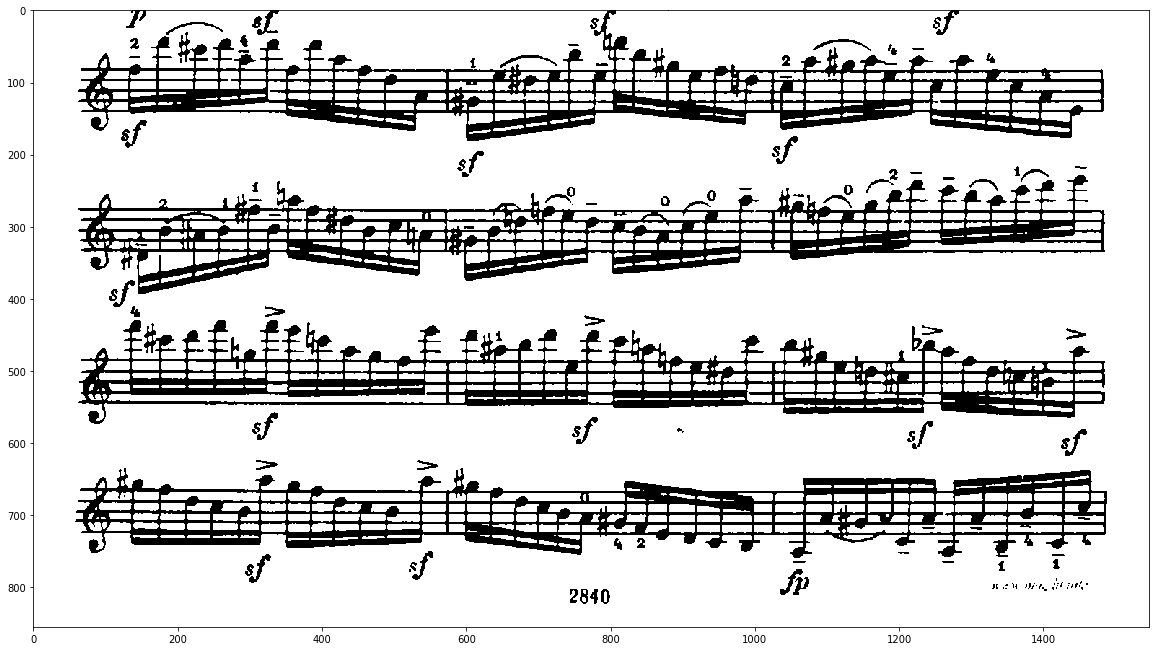

In [488]:
# Filter out the gray stuff, custom step
ret, thresh = cv2.threshold(note, 127, 255, cv2.THRESH_BINARY)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(thresh, 'gray')

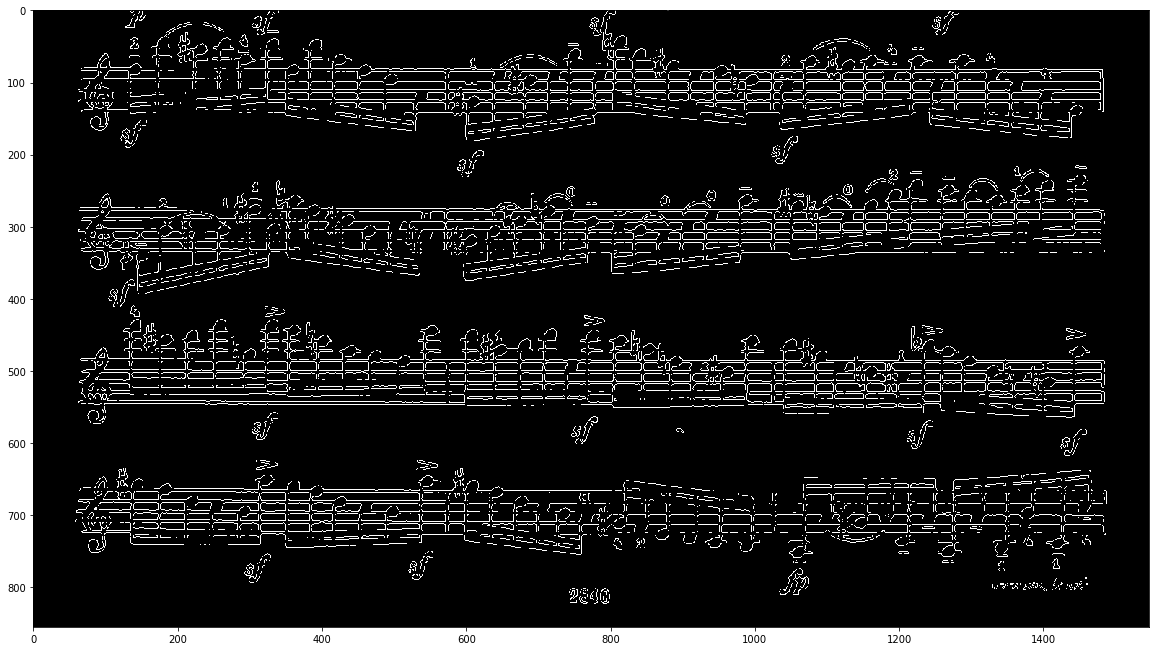

In [489]:
# Detect horizontal edges
edges = cv2.Canny(thresh, 100, 200, None, 3)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(edges,cmap = 'gray')

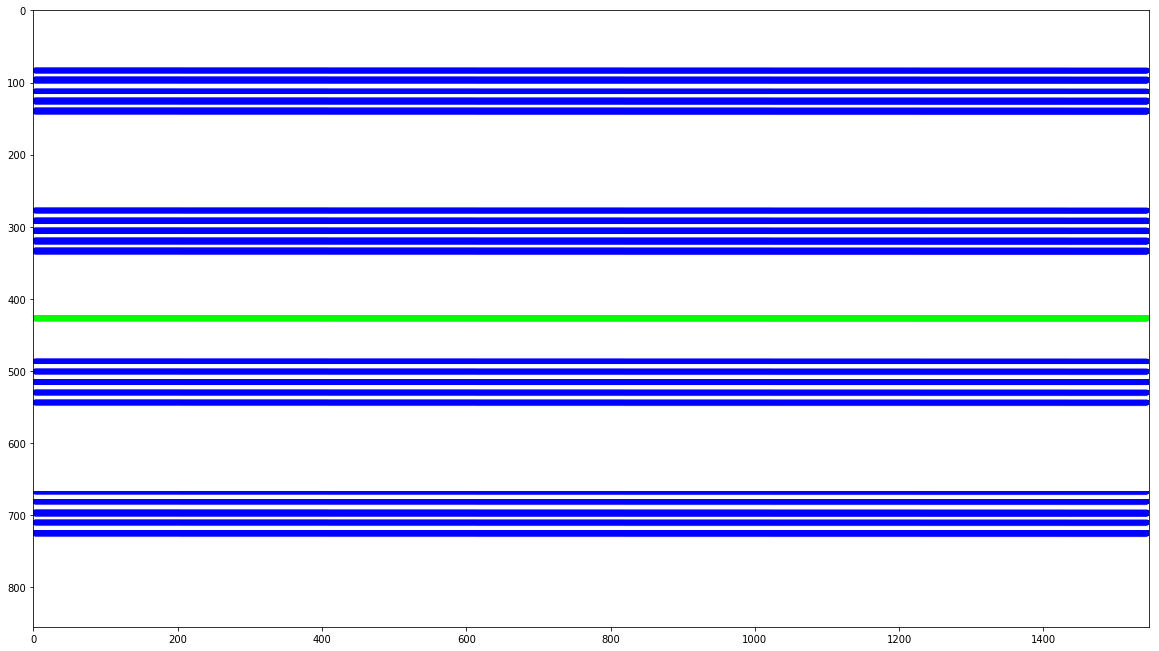

In [490]:
def display_line(img, rho, theta, thicc=3, color=(0, 0, 0)):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 3000*(-b)), int(y0 + 3000*(a)))
    pt2 = (int(x0 - 3000*(-b)), int(y0 - 3000*(a)))
    cv2.line(img, pt1, pt2, color, thicc, cv2.LINE_AA)

# Copy of image
#bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
bgr_thresh = np.ones((note.shape[0], note.shape[1], 3), dtype=np.uint8) * 255

# Find lines from edges
lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)
assert lines is not None

# Predominant angle
thetas = lines[:, 0, 1]
thetas_std = np.std(thetas)
thetas_mean = np.mean(thetas)
thetas = thetas[(thetas_mean - thetas_std - 1e-4 < thetas) &
                (thetas < thetas_mean + thetas_std + 1e-4)]
predominant_angle = np.median(thetas)

# Filter out lines that does not match the dominant direction
thetas = lines[:, 0, 1]
lines = lines[(predominant_angle - 1e-2 < thetas) &
              (thetas < predominant_angle + 1e-2)]

# Sort the lines by rho value
rhos = lines[:, 0, 0]
args = np.argsort(rhos)
lines = lines[args, :, :]

# Visualize lines and the dominant direction
rho = bgr_thresh.shape[0] // 2
theta = predominant_angle
display_line(bgr_thresh, rho, theta, 7, (0, 255, 0))
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    display_line(bgr_thresh, rho, theta, 3, (0, 0, 255))
plt.figure(figsize=(20, 12))
plt.imshow(bgr_thresh, 'gray')

In [491]:
# TODO: Rotate the image in such a way, so that the predominant angle
# become horizontal
predominant_angle = predominant_angle

in-band range: 13.0 ... 15.0
ex-band range: 125.0 ... 152.0
number of bands: 4
before filtering lines: 39  lines
after filtering proper lines: 20  lines


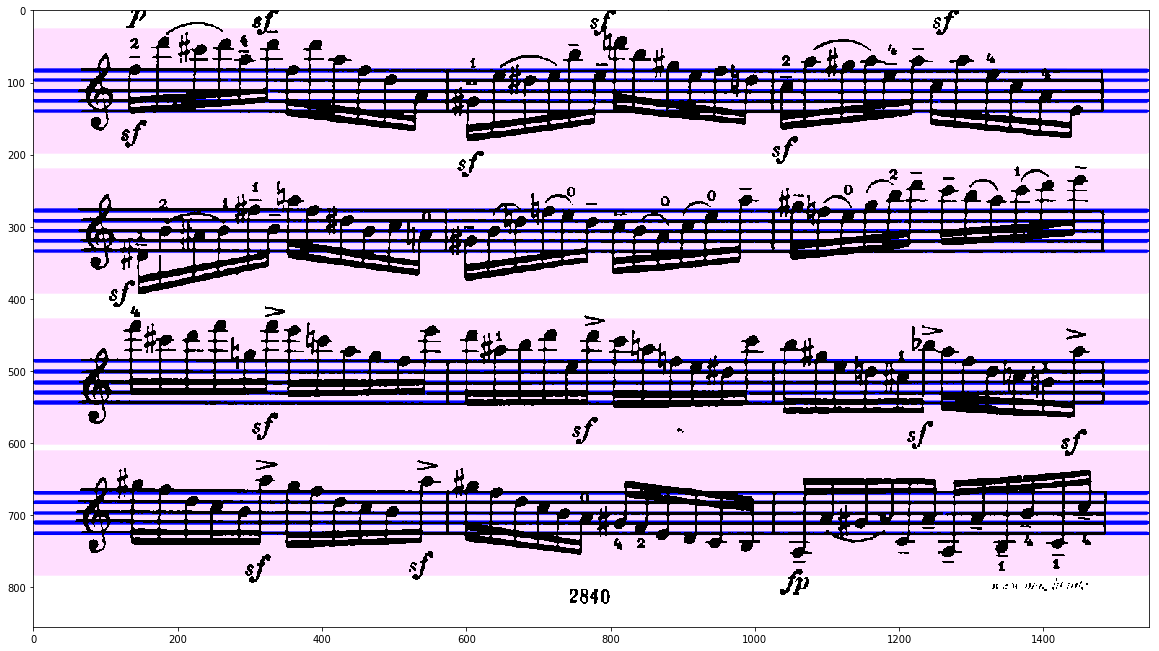

In [492]:
# Filter out the lines that are too close to each other
linewidth_threshold = 7
proper_lines = []
lines_pool = []
prev_rho = None
for i in range(len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    if prev_rho is None:
        prev_dst = 1000000
    else:
        prev_dst = abs(rho - prev_rho)
    if len(lines_pool) != 0:
        if prev_dst > linewidth_threshold:
            avg_rho = np.round(np.mean(np.array(lines_pool)[:, 0]))
            avg_theta = np.mean(np.array(lines_pool)[:, 1])
            proper_lines.append([avg_rho, avg_theta])
            lines_pool = []
    prev_rho = rho
    lines_pool.append([rho, theta])

avg_rho = np.mean(np.array(lines_pool)[:, 0])
avg_theta = np.mean(np.array(lines_pool)[:, 1])
proper_lines.append([avg_rho, avg_theta])
proper_lines = np.array(proper_lines)[:, np.newaxis, :]

# Find the bands
rho_cp = proper_lines[:, 0, 0].copy()
rho_le = np.concatenate((np.zeros((1)), rho_cp))
rho_ri = np.concatenate((rho_cp, np.zeros((1))))
rho_dt = rho_le - rho_ri
rho_dt = np.abs(rho_dt[1:-1])
rho_inband_min = np.min(rho_dt)
rho_exband_max = np.max(rho_dt)
rho_inband_max = rho_inband_min
rho_exband_min = rho_exband_max
for rho in rho_dt:
    if abs(rho - rho_inband_min) < abs(rho - rho_exband_max):
        rho_inband_max = max(rho, rho_inband_max)
    else:
        rho_exband_min = min(rho, rho_exband_min)
print('in-band range:', rho_inband_min, '...', rho_inband_max)
print('ex-band range:', rho_exband_min, '...', rho_exband_max)
band_list = []
band_pool = []
prev_rho = None
for i in range(len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    if prev_rho is not None:
        if abs(rho - prev_rho) <= rho_inband_max:
            None
        if abs(rho - prev_rho) >= rho_exband_min:
            band_pool = np.array(band_pool)
            band_list.append([
                np.round(np.mean(band_pool[:, 0])),
                np.mean(band_pool[:, 1]),
                abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
            band_pool = []
    band_pool.append([rho, theta])
    prev_rho = rho
band_pool = np.array(band_pool)
band_list.append([
    np.round(np.mean(band_pool[:, 0])),
    np.mean(band_pool[:, 1]),
    abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
band_list = np.array(band_list)[:, np.newaxis, :]
print('number of bands:', band_list.shape[0])

# Visualize the proper lines
print('before filtering lines:', lines.shape[0], ' lines')
print('after filtering proper lines:', proper_lines.shape[0], ' lines')
white = np.ones(bgr_thresh.shape, dtype=np.uint8) * 255
bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for i in range(0, len(band_list)):
    rho = band_list[i][0][0]
    theta = band_list[i][0][1]
    thicc = band_list[i][0][2]
    display_line(white, rho, theta, int(thicc + rho_exband_min - 10), (255, 222, 255))
for i in range(0, len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    display_line(white, rho, theta, 3, (0, 0, 255))
bgr_thresh = np.minimum(bgr_thresh, white)
plt.figure(figsize=(20, 12))
plt.imshow(bgr_thresh, 'gray')

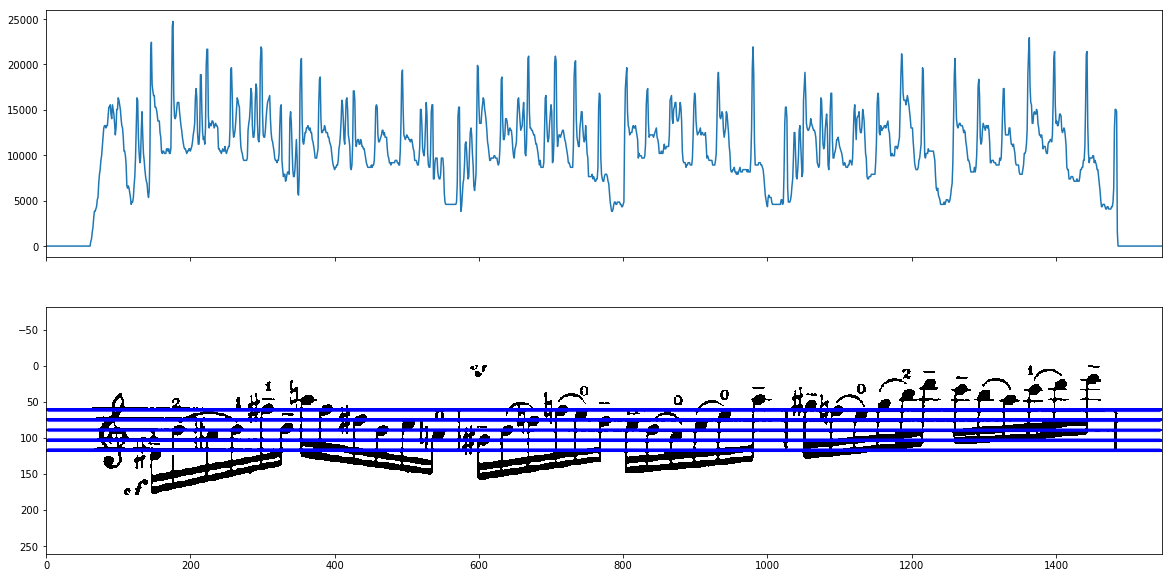

In [619]:
band_index = 1

rho = band_list[band_index, 0, 0]
theta = band_list[band_index, 0, 1]
thicc = band_list[band_index, 0, 2]
rho_lo = int(rho - ((thicc + rho_exband_min) // 2))
rho_hi = int(rho + ((thicc + rho_exband_min) // 2))
band_i = thresh[rho_lo:rho_hi, :].copy()
band_i_color = cv2.cvtColor(band_i, cv2.COLOR_GRAY2BGR)
whites = np.ones(band_i_color.shape, dtype=np.uint8) * 255

lines = proper_lines[int(band_index * 5):int(band_index * 5 + 5), :, :].copy()
lines[:, 0, 0] = lines[:, 0, 0] - rho_lo
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    display_line(band_i_color, rho, theta, 3, (0, 0, 255))

blacks = np.sum(255 - band_i, axis=0)
blacks_x = np.arange(0, blacks.shape[0], 1)

# Visualization
f, axes = plt.subplots(2, sharex=True, figsize=(20, 10))
axes[0].plot(blacks_x, blacks)
axes[1].imshow(band_i_color, 'gray')

14
15
(1547,) (1547,)


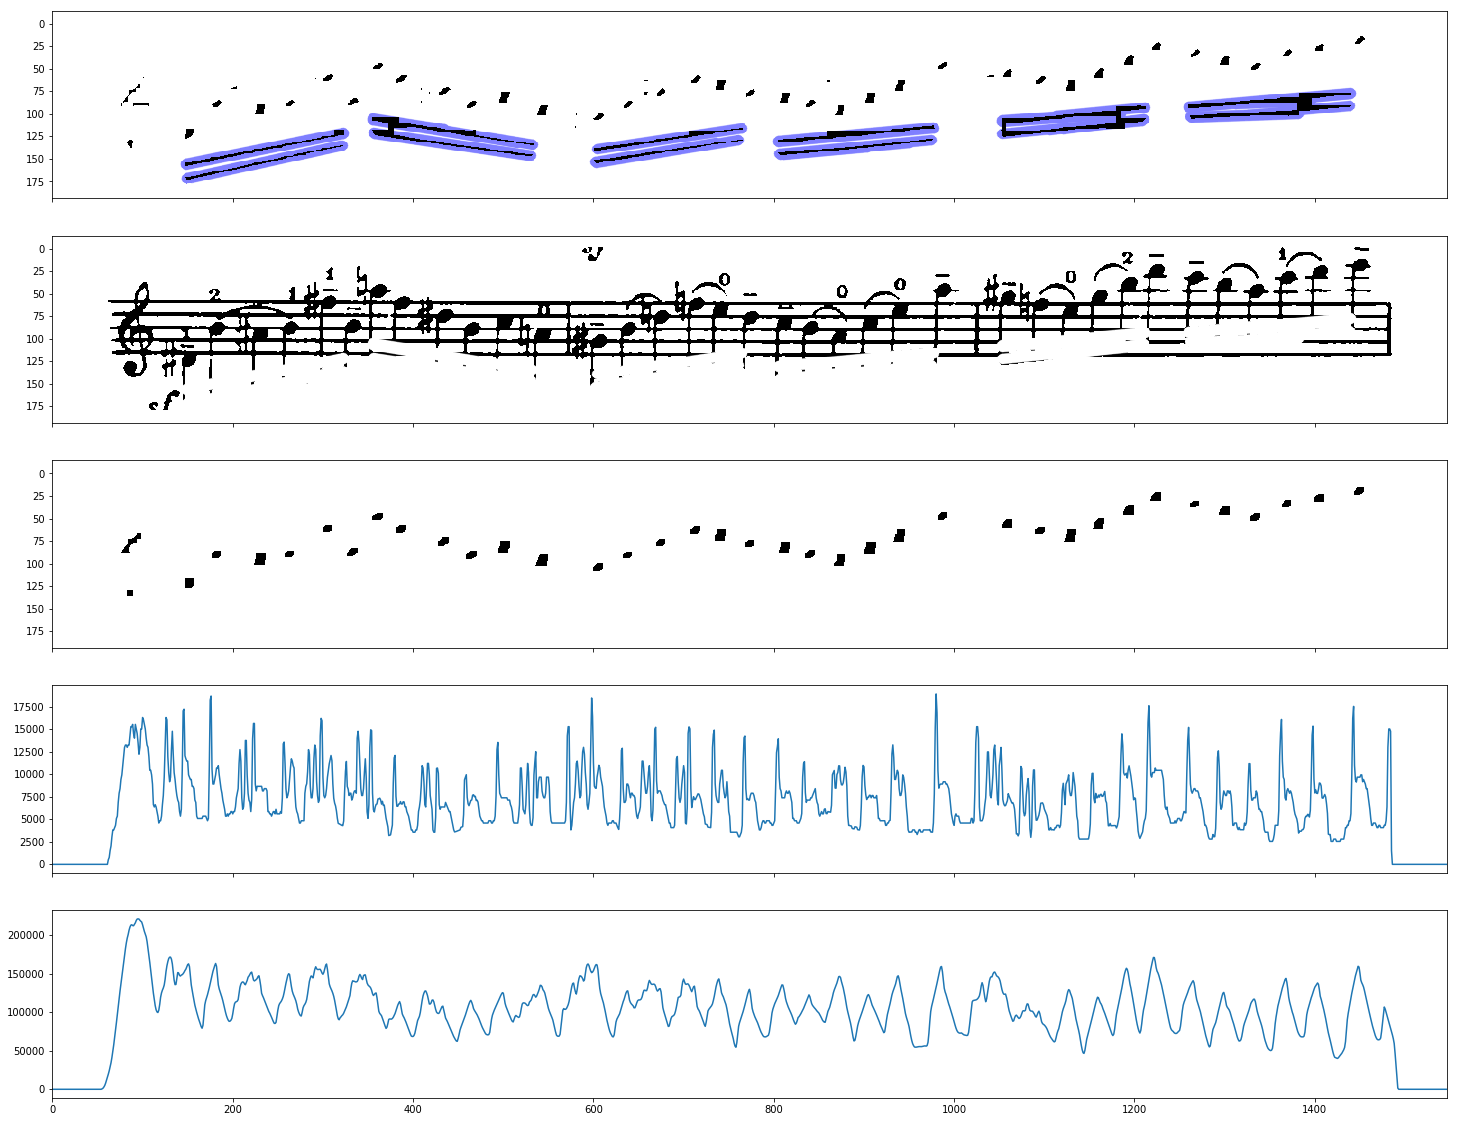

In [565]:
band_i_copy = band_i.copy()

# Getting rid of the thicc lines
kernel3 = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(band_i_copy, kernel3, iterations=3)
dilated_color = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
whites = np.ones(dilated_color.shape, dtype=np.uint8) * 255
linesP = cv2.HoughLinesP(255 - dilated, 1, np.pi / 180, 100, None, 80, 15)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(band_i_copy, (l[0], l[1]), (l[2], l[3]), (255), 10, cv2.LINE_AA)
        cv2.line(whites, (l[0], l[1]), (l[2], l[3]), (127,127,255), 10, cv2.LINE_AA)

# Calculate histogram
blacks = np.sum(255 - band_i_copy, axis=0)
blacks_x = np.arange(0, blacks.shape[0], 1)

# Do some convolutions
lines = proper_lines[int(band_index * 5):int(band_index * 5 + 5), :, :].copy()
lines[:, 0, 0] = lines[:, 0, 0] - rho_lo
inband_range = int(np.round((lines[-1, 0, 0] - lines[0, 0, 0]) / 4))
note_height = inband_range
print(inband_range)
note_width = int(inband_range)
if note_width % 2 == 0:
    note_width += 1
print(note_width)
conv_kernel = np.ones((note_width))
conv_band = np.convolve(blacks, conv_kernel)[int(note_width//2):int(-(note_width//2))]
print(blacks.shape, conv_band.shape)

# Creative morphology
kernel_delhor = np.ones((3, 1), np.uint8)
kernel_delver = np.ones((1, 3), np.uint8)
morphed = cv2.dilate(band_i_copy, kernel_delhor, iterations=5)
morphed = cv2.erode(morphed, kernel_delhor, iterations=5)
morphed = cv2.dilate(morphed, kernel_delver, iterations=5)
morphed = cv2.erode(morphed, kernel_delver, iterations=5)
morphed = cv2.dilate(morphed, kernel3, iterations=2)

# Visualization
dilated_color = np.minimum(dilated_color, whites)
f, axes = plt.subplots(5, sharex=True, figsize=(25, 20))
axes[0].imshow(dilated_color, 'gray')
axes[1].imshow(band_i_copy, 'gray')
axes[3].plot(blacks_x, blacks)
axes[4].plot(blacks_x, conv_band)
axes[2].imshow(morphed, 'gray')

38
-1


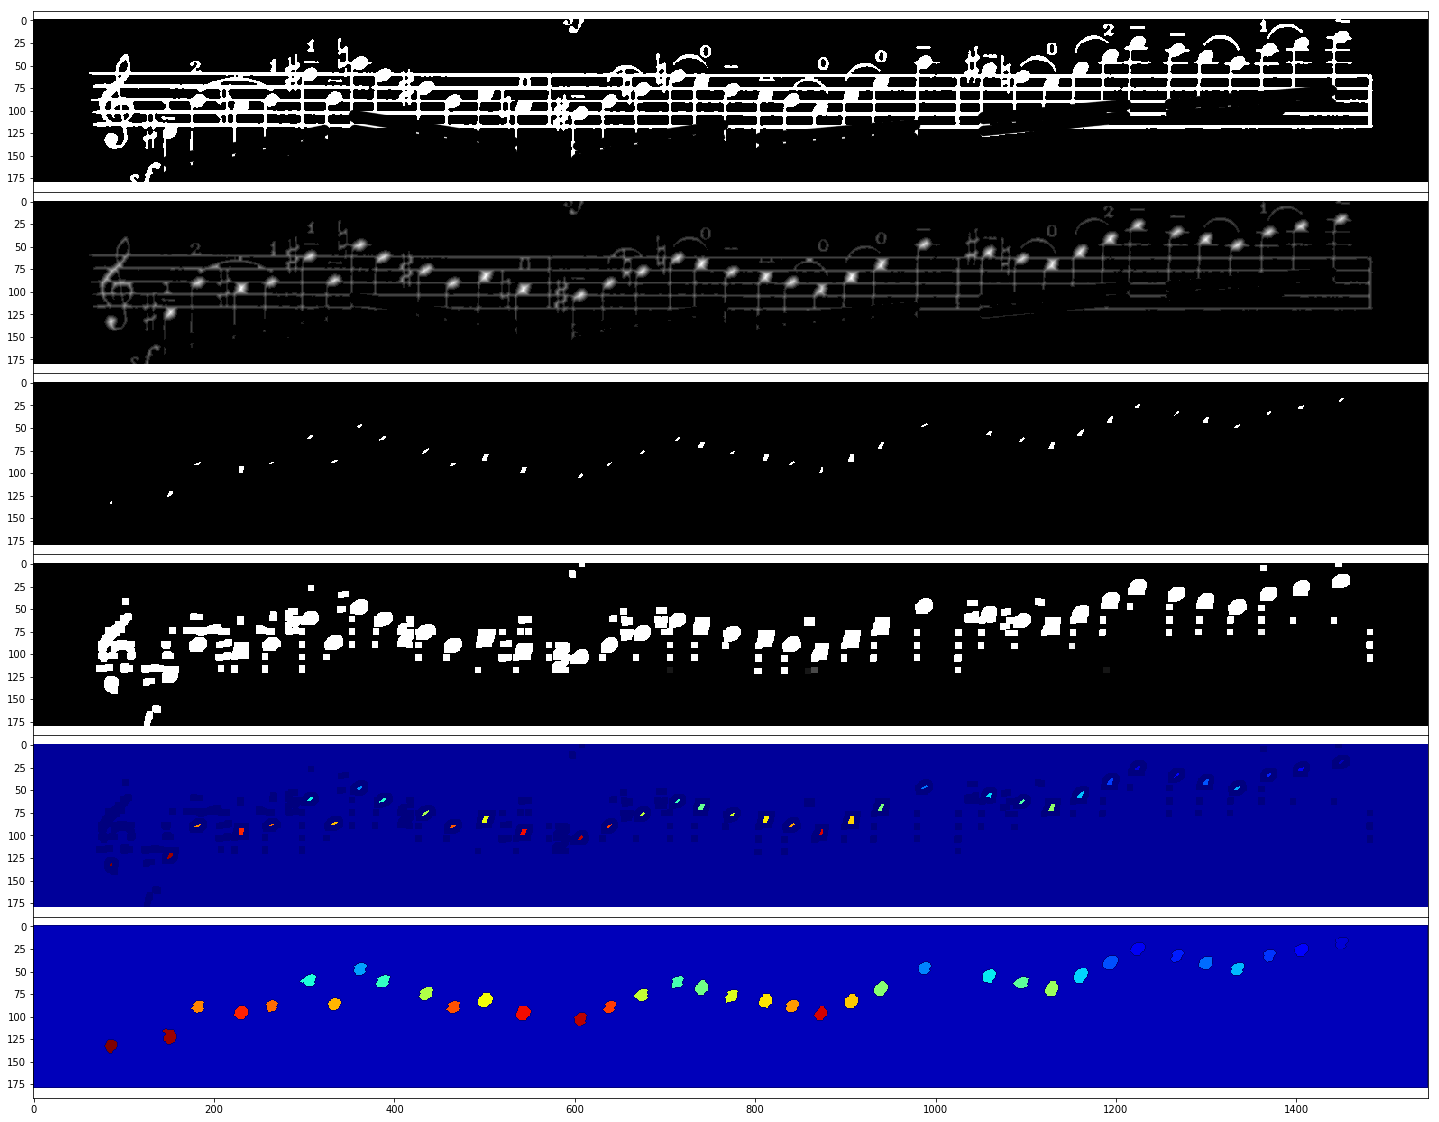

In [618]:
band_reverse = 255 - band_i_copy

# Erode a bit
kernel3 = np.ones((3,3),np.uint8) 
opening = cv2.morphologyEx(band_reverse,cv2.MORPH_OPEN,kernel3, iterations = 2)

# Find sure background
sure_bg = cv2.dilate(opening,kernel3,iterations=1)

# Find pixels that surely belogns to notes
dist_transform = cv2.distanceTransform(band_reverse, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
pre_markers = markers.copy()

# Watershed
markers = cv2.watershed(cv2.cvtColor(band_i, cv2.COLOR_GRAY2BGR), markers)
#img[wshed == -1] = [255,0,0]

print(markers.max())
print(markers.min())

# Visualization
f, axes = plt.subplots(6, sharex=True, figsize=(25, 20))
axes[0].imshow(band_reverse, 'gray')
axes[1].imshow(dt, 'gray')
axes[2].imshow(sure_fg, 'gray')
axes[3].imshow(sure_bg, 'gray')
axes[4].imshow(pre_markers, cmap='jet')
axes[5].imshow(markers, cmap='jet')
f.subplots_adjust(hspace=0)

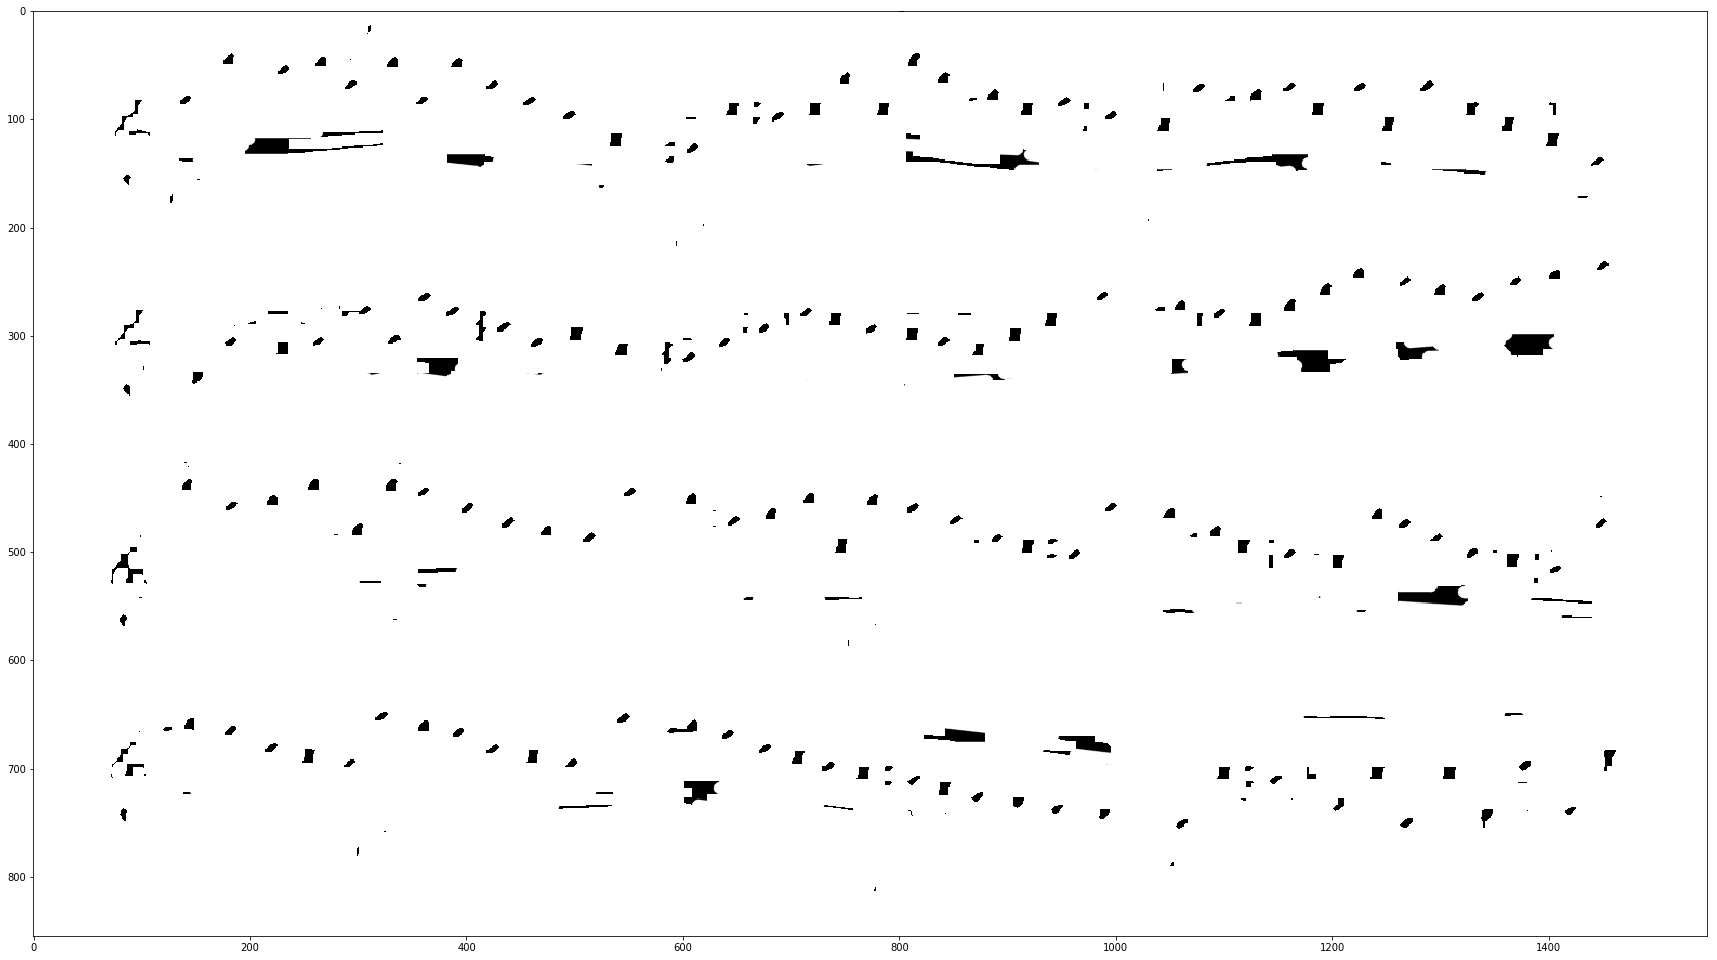

In [408]:
# Let's try to recognize the dots
morphed = thresh.copy()
kernel3 = np.ones((3, 3), np.uint8)
kernel5 = np.ones((5, 5), np.uint8)
eroded = cv2.erode(morphed, kernel3, iterations=1)
morphed = cv2.dilate(eroded, kernel3, iterations=4)
#morphed = cv2.erode(morphed, kernel3, iterations=1)

ero_edges = cv2.Canny(morphed, 100, 200, None, 3)
white = np.ones((morphed.shape[0], morphed.shape[1], 3), dtype=np.uint8) * 255
linesP = cv2.HoughLinesP(ero_edges, 1, np.pi / 180, 60, None, 30, 10)
thresh_nobrows = thresh.copy()
morphed = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(thresh_nobrows, (l[0], l[1]), (l[2], l[3]), (255), 10, cv2.LINE_AA)
        cv2.line(morphed, (l[0], l[1]), (l[2], l[3]), (255,255,255), 10, cv2.LINE_AA)

# Visualization
plt.figure(figsize=(30, 20))
plt.imshow(morphed, 'gray')

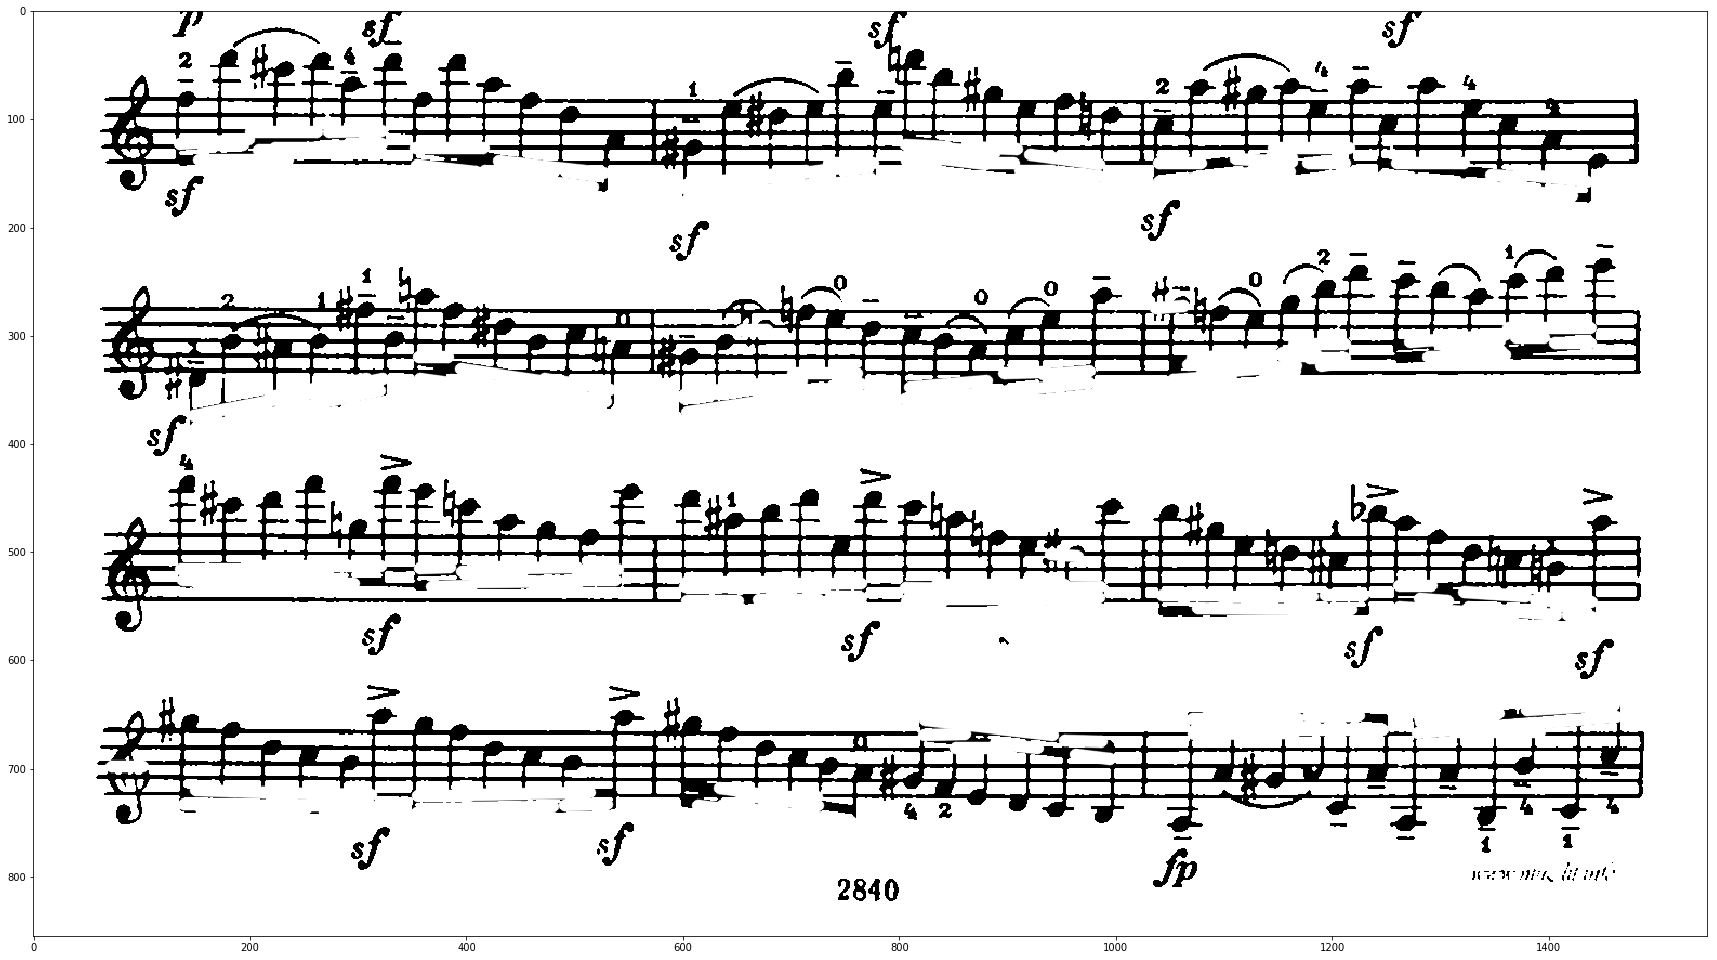

In [403]:
# Let's try to recognize the dots
morphed = thresh_nobrows.copy()
kernel3 = np.ones((3, 3), np.uint8)
kernel5 = np.ones((5, 5), np.uint8)
#morphed = cv2.erode(morphed, kernel3, iterations=1)
morphed = cv2.dilate(morphed, kernel3, iterations=3)
#morphed = cv2.erode(morphed, kernel3, iterations=1)

ero_edges = cv2.Canny(morphed, 100, 200, None, 3)
white = np.ones((morphed.shape[0], morphed.shape[1], 3), dtype=np.uint8) * 255
linesP = cv2.HoughLinesP(ero_edges, 1, np.pi / 180, 40, None, 20, 12)
thresh_nobrows2 = thresh_nobrows.copy()
morphed = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(thresh_nobrows2, (l[0], l[1]), (l[2], l[3]), (255,255,255), 10, cv2.LINE_AA)
        cv2.line(morphed, (l[0], l[1]), (l[2], l[3]), (255,0,0), 10, cv2.LINE_AA)

# Visualization
plt.figure(figsize=(30, 20))
plt.imshow(thresh_nobrows2, 'gray')

In [396]:
class Rectangle(object):
    def __init__(self, x, y, w, h):
        self.x = x;
        self.y = y;
        self.w = w;
        self.h = h;
        self.middle = self.x + self.w/2, self.y + self.h/2
        self.area = self.w * self.h

    def overlap(self, other):
        overlap_x = max(0, min(self.x + self.w, other.x + other.w) - max(self.x, other.x));
        overlap_y = max(0, min(self.y + self.h, other.y + other.h) - max(self.y, other.y));
        overlap_area = overlap_x * overlap_y
        return overlap_area / self.area

    def distance(self, other):
        dx = self.middle[0] - other.middle[0]
        dy = self.middle[1] - other.middle[1]
        return math.sqrt(dx*dx + dy*dy)

    def merge(self, other):
        x = min(self.x, other.x)
        y = min(self.y, other.y)
        w = max(self.x + self.w, other.x + other.w) - x
        h = max(self.y + self.h, other.y + other.h) - y
        return Rectangle(x, y, w, h)

    def draw(self, img, color, thickness):
        pos = ((int)(self.x), (int)(self.y))
        size = ((int)(self.x + self.w), (int)(self.y + self.h))
        cv2.rectangle(img, pos, size, color, thickness)


def fit(img, templates, start_percent, stop_percent, threshold):
    img_width, img_height = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    # plt.axis([0, 2, 0, 1])
    # plt.show(block=False)

    x = []
    y = []
    for scale in [float(i)/100.0 for i in range(start_percent, stop_percent + 1, 3)]:
        locations = []
        location_count = 0
        for template in templates:
            template = cv2.resize(template, (0, 0),
                fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
            result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            result = np.where(result >= threshold)
            location_count += len(result[0])
            locations += [result]
        # print("scale: {0}, hits: {1}".format(scale, location_count))
        x.append(location_count)
        y.append(scale)
        # plt.plot(y, x)
        # plt.pause(0.00001)
        if (location_count > best_location_count):
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
            # plt.axis([0, 2, 0, best_location_count])
        elif (location_count < best_location_count):
            pass
    # plt.close()
    return best_locations, best_scale, x, y

def locate_images(img, templates, start, stop, threshold):
    locations, scale, x, y = fit(img, templates, start, stop, threshold)
    img_locations = []
    for i in range(len(templates)):
        w, h = templates[i].shape[::-1]
        w *= scale
        h *= scale
        img_locations.append([Rectangle(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
    return img_locations, x, y

def merge_recs(recs, threshold):
    filtered_recs = []
    while len(recs) > 0:
        r = recs.pop(0)
        recs.sort(key=lambda rec: rec.distance(r))
        merged = True
        while(merged):
            merged = False
            i = 0
            for _ in range(len(recs)):
                if r.overlap(recs[i]) > threshold or recs[i].overlap(r) > threshold:
                    r = r.merge(recs.pop(i))
                    merged = True
                elif recs[i].distance(r) > r.w/2 + recs[i].w/2:
                    break
                else:
                    i += 1
        filtered_recs.append(r)
    return filtered_recs


staff_files = [
    "./template/staff2.png", 
    "./template/staff.png"]
quarter_files = [
    "./template/quarter.png", 
    "./template/solid-note.png"]
sharp_files = [
    "./template/sharp.png"]
flat_files = [
    "./template/flat-line.png", 
    "./template/flat-space.png" ]
half_files = [
    "./template/half-space.png", 
    "./template/half-note-line.png",
    "./template/half-line.png", 
    "./template/half-note-space.png"]
whole_files = [
    "./template/whole-space.png", 
    "./template/whole-note-line.png",
    "./template/whole-line.png", 
    "./template/whole-note-space.png"]

staff_imgs = [cv2.imread(staff_file, 0) for staff_file in staff_files]
quarter_imgs = [cv2.imread(quarter_file, 0) for quarter_file in quarter_files]
sharp_imgs = [cv2.imread(sharp_files, 0) for sharp_files in sharp_files]
flat_imgs = [cv2.imread(flat_file, 0) for flat_file in flat_files]
half_imgs = [cv2.imread(half_file, 0) for half_file in half_files]
whole_imgs = [cv2.imread(whole_file, 0) for whole_file in whole_files]

staff_lower, staff_upper, staff_thresh = 50, 150, 0.77
sharp_lower, sharp_upper, sharp_thresh = 50, 150, 0.70
flat_lower, flat_upper, flat_thresh = 50, 150, 0.77
quarter_lower, quarter_upper, quarter_thresh = 50, 150, 0.60
half_lower, half_upper, half_thresh = 50, 150, 0.70
whole_lower, whole_upper, whole_thresh = 50, 150, 0.70

Matching quarter image...
Merging quarter image results...


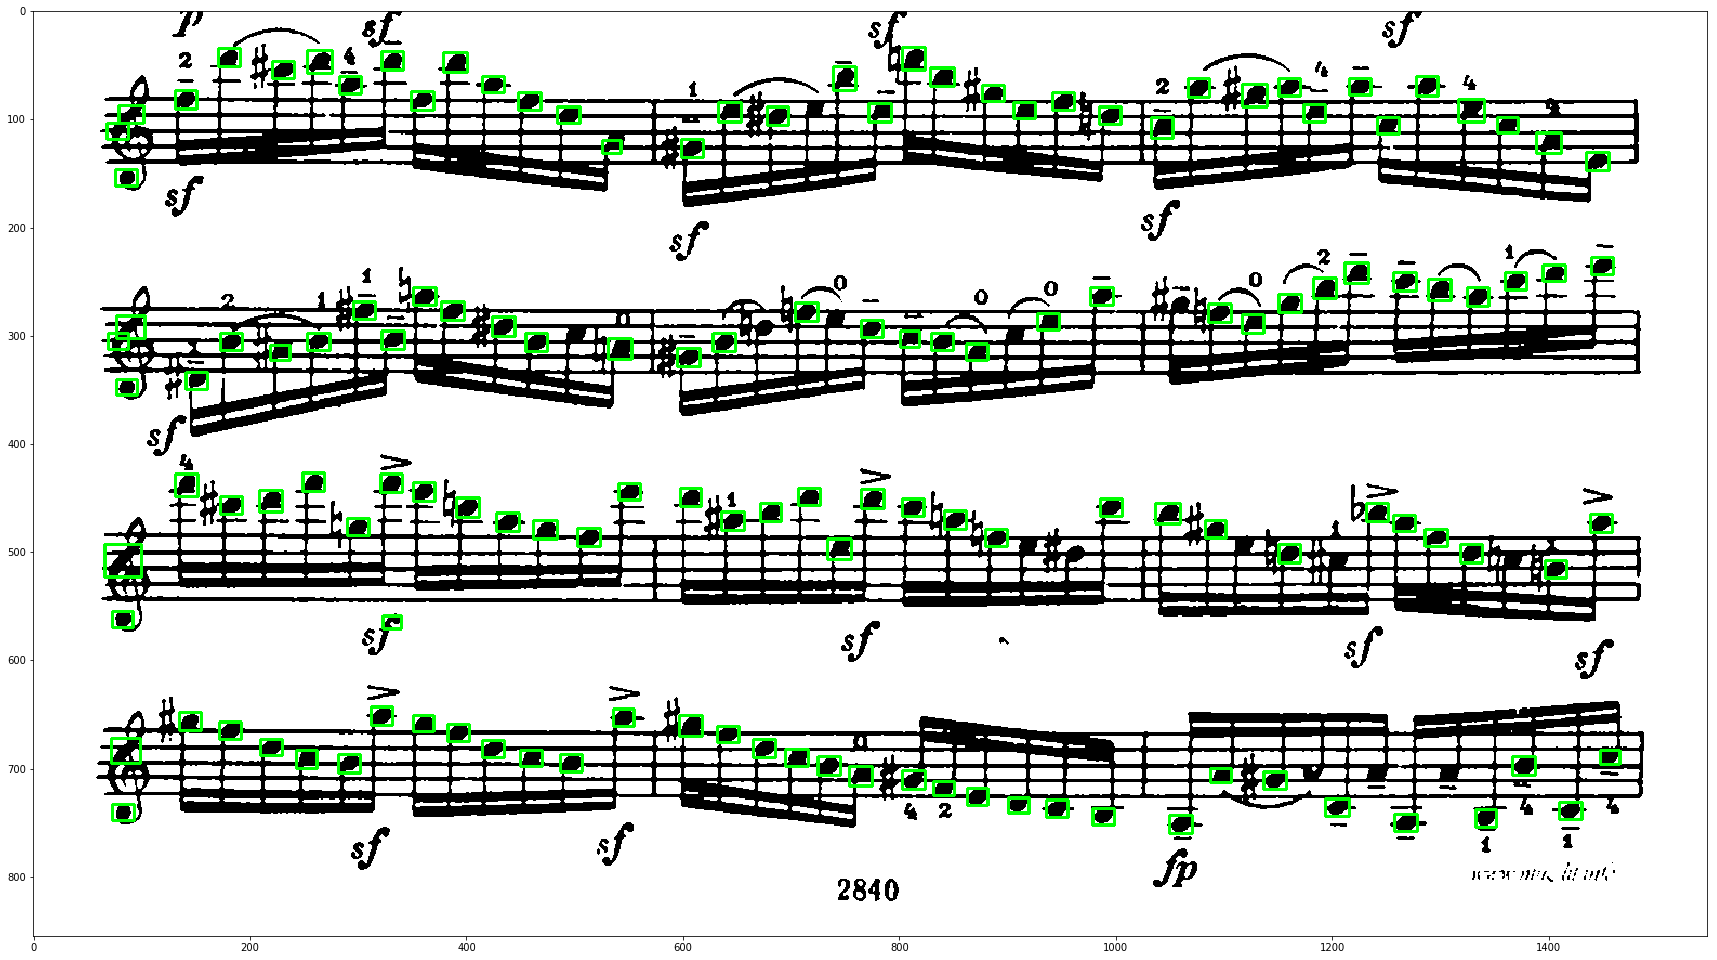

In [397]:
img_gray = thresh_nobrows2.copy()
#img_gray = thresh.copy()

print("Matching quarter image...")
quarter_recs, x, y = locate_images(img_gray, quarter_imgs, quarter_lower, quarter_upper, quarter_thresh)

print("Merging quarter image results...")
quarter_recs = merge_recs([j for i in quarter_recs for j in i], 0.3)
quarter_recs_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for r in quarter_recs:
    r.draw(quarter_recs_img, (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(30, 20))
#plt.plot(y, x)
#cv2.imwrite('quarter_recs_img.png', quarter_recs_img)
plt.imshow(quarter_recs_img)